### Importing the necessary libraries

In [1]:
import yfinance as yf

In [2]:
sony_info = yf.Ticker("SONY")
sony_history = sony_info.history(period="max")

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN

In [57]:
# CONSTANT PARAMETERS
EPOCH_COUNT = 40
BATCH_SIZE = 32

### Plot closing price data over time

In [6]:
# Get closing price column from the dataframe
closing_price_data = sony_history.iloc[:,3:4]
closing_price_data = closing_price_data.rename(columns={"Close": "Closing Price"})
closing_price_data.head()

,Closing Price
Date,
1973-02-21 00:00:00-05:00,5.828178
1973-02-22 00:00:00-05:00,5.691688
1973-02-23 00:00:00-05:00,5.582494
1973-02-26 00:00:00-05:00,5.500598
1973-02-27 00:00:00-05:00,5.377757


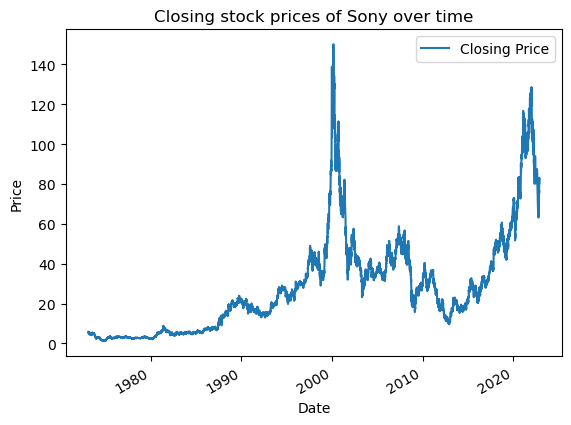

In [7]:
# Plot the closing stock price data
closing_price_data.plot()
plt.ylabel("Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

### Scale the data

In [8]:
# Scale the data using Min-Max scaling to reduce computational cost.
scaler = MinMaxScaler()
closing_price_data_scaled = scaler.fit_transform(closing_price_data)

# The following logical comparison concludes that there are no NaN values.
len(closing_price_data.isna()) == len(closing_price_data)
closing_price_data_scaled_df = pd.DataFrame(closing_price_data_scaled)
closing_price_data_scaled_df.index = closing_price_data.index
closing_price_data_scaled_df = closing_price_data_scaled_df.rename(columns={0:"Closing Price"})
closing_price_data_scaled_df.head()

,Closing Price
Date,
1973-02-21 00:00:00-05:00,0.031057
1973-02-22 00:00:00-05:00,0.030140
1973-02-23 00:00:00-05:00,0.029407
1973-02-26 00:00:00-05:00,0.028857
1973-02-27 00:00:00-05:00,0.028032


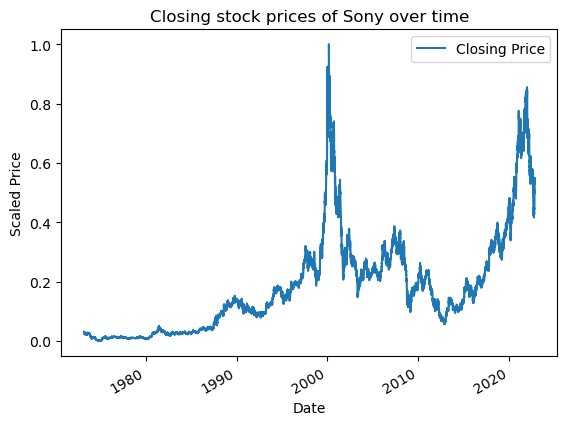

In [9]:
# Plot the scaled closing stock price data
closing_price_data_scaled_df.plot()
plt.ylabel("Scaled Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

### Creation of train data and label sequences

In [10]:
# Function to generate train sample and test label sequences
def get_data_splits(data, train_size = 20, label_count = 1):
    train_sets = np.empty((0, train_size))
    labels = np.empty((0, label_count))
    length = len(data)
    for i in range(0, length):
        if (i + train_size) >= length:
            break
        # # ----------Debugging code start-----------------------------------------
        # print("Train: ", i, "to", i + train_size - 1)
        # print("Predict: ", (i + train_size), "to",
        #       (i + train_size + label_count - 1))
        # # ----------Debugging code end-------------------------------------------
        train_sets = np.append(
            train_sets, [data[i:(i + train_size)].reshape(train_size,)], axis=0)
        labels = np.append(labels, [data[(
            i + train_size):(i + train_size + label_count)].reshape(label_count,)], axis=0)

    return train_sets.reshape(len(train_sets), train_size, 1), labels.reshape(len(labels), label_count, 1)


In [11]:
# Splitting the dataset
length = len(closing_price_data_scaled)
train_sample_count = round(0.60 * length)
remaining_sample_count = length - train_sample_count
val_sample_count = round(0.50 * remaining_sample_count)

training_set = closing_price_data_scaled[0:train_sample_count]
validation_set = closing_price_data_scaled[train_sample_count:(
    train_sample_count + val_sample_count)]
testing_set = closing_price_data_scaled[(
    train_sample_count + val_sample_count):length]

In [12]:
len(training_set), len(validation_set), len(testing_set)

(7529, 2510, 2510)

In [13]:
# Get the train features, train labels, test features, test labels
train_size = 20
label_count = 1
X_train, y_train = get_data_splits(training_set, train_size, label_count)
X_val, y_val = get_data_splits(validation_set, train_size, label_count)
X_test, y_test = get_data_splits(testing_set, train_size, label_count)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

7509 7509
2490 2490
2490 2490


### Some helper functions

In [14]:
def plot_training_history(fitted_model):
    # Training/validation loss and accuracy curve
    pd.DataFrame(fitted_model.history).plot()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss - Accuracy")
    plt.tight_layout()
    plt.show()

def plot_result(y_train, y_test, train_predict, test_predict):
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 8), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(y_train), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title(
        'Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


### Vanilla RNN baseline

In [15]:
def create_RNN_vanilla(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

n_hidden_units = 64
n_dense_units = 1
input_shape = (train_size, 1)

In [58]:
# Create vanilla RNN model
vanilla_rnn = create_RNN_vanilla(n_hidden_units, n_dense_units,
                         input_shape, activation='tanh')
vanilla_rnn.summary()

# Training the vanilla RNN
with tf.device('/cpu:0'):
    fitted_vanilla_rnn = vanilla_rnn.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
  5/235 [..............................] - ETA: 3s - loss: 0.0050  

2022-11-19 19:11:25.896487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/235 [============================>.] - ETA: 0s - loss: 4.3625e-04

2022-11-19 19:11:28.880821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 15ms/step - loss: 4.3361e-04 - val_loss: 3.1827e-04
Epoch 2/40
235/235 [==============================] - 3s 15ms/step - loss: 1.4628e-04 - val_loss: 7.3396e-05
Epoch 3/40
235/235 [==============================] - 3s 14ms/step - loss: 1.2697e-04 - val_loss: 1.7912e-04
Epoch 4/40
235/235 [==============================] - 4s 15ms/step - loss: 1.1569e-04 - val_loss: 8.1297e-05
Epoch 5/40
235/235 [==============================] - 3s 14ms/step - loss: 1.1702e-04 - val_loss: 2.1727e-04
Epoch 6/40
235/235 [==============================] - 4s 15ms/step - loss: 1.0488e-04 - val_loss: 9.7616e-05
Epoch 7/40
235/235 [==============================] - 3s 15ms/step - loss: 1.0128e-04 - val_loss: 7.8895e-05
Epoch 8/40
235/235 [==============================] - 3s 15ms/step - loss: 1.0521e-04 - val_loss: 9.9046e-05
Epoch 9/40
235/235 [==============================] - 4s 15ms/step - loss: 9.5722e-05 - val_loss: 7.4273e-05
Epoch 10/40
235/235 [=========

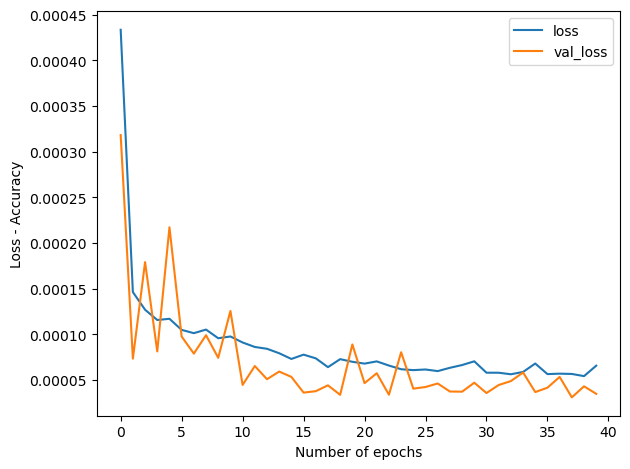

loss: 3.098329034401104e-05


In [ ]:
plot_training_history(fitted_vanilla_rnn)

 14/235 [>.............................] - ETA: 1s

2022-11-19 19:13:43.991216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 8ms/step


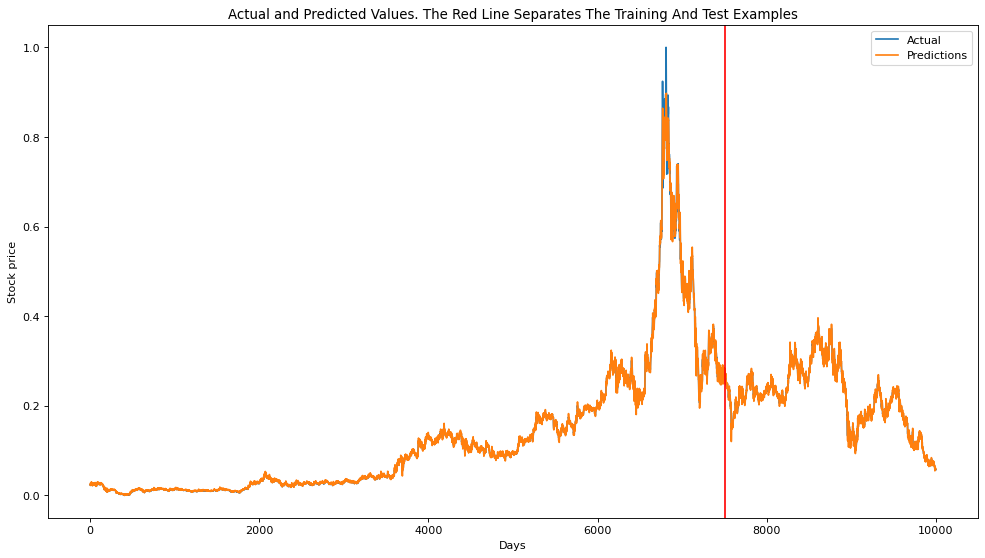

In [60]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_vanilla = fitted_vanilla_rnn.model.predict(X_train)
    val_predict_vanilla = fitted_vanilla_rnn.model.predict(X_val)
plot_result(y_train, y_val, train_predict_vanilla, val_predict_vanilla)

### Experimentation on vanilla RNN

##### Adding more layers

In [61]:
# Creating RNN with multiple layers
def create_RNN_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(hidden_units_list[0], input_shape=input_shape,
                        activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(SimpleRNN(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(SimpleRNN(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (train_size, 1)

In [62]:
rnn_1 = create_RNN_1(n_hidden_units_list, n_dense_units,
                   input_shape, activation='tanh')
rnn_1.summary()

# Training the RNN with multiple SimpleRNN layers
with tf.device('/cpu:0'):
    fitted_rnn_1 = rnn_1.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_27 (SimpleRNN)   (None, 20, 64)            4224      
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 20, 64)            8256      
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-11-19 19:13:47.369106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0108

2022-11-19 19:13:54.643596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 10s 37ms/step - loss: 0.0108 - val_loss: 1.1289e-04
Epoch 2/40
235/235 [==============================] - 9s 37ms/step - loss: 1.7941e-04 - val_loss: 1.5501e-04
Epoch 3/40
235/235 [==============================] - 9s 39ms/step - loss: 1.8137e-04 - val_loss: 6.0020e-05
Epoch 4/40
235/235 [==============================] - 9s 38ms/step - loss: 1.5729e-04 - val_loss: 2.2855e-04
Epoch 5/40
235/235 [==============================] - 9s 40ms/step - loss: 1.3811e-04 - val_loss: 5.2447e-05
Epoch 6/40
235/235 [==============================] - 9s 38ms/step - loss: 1.4537e-04 - val_loss: 9.7295e-05
Epoch 7/40
235/235 [==============================] - 9s 37ms/step - loss: 1.2835e-04 - val_loss: 5.0398e-05
Epoch 8/40
235/235 [==============================] - 9s 38ms/step - loss: 1.4748e-04 - val_loss: 7.7360e-05
Epoch 9/40
235/235 [==============================] - 9s 38ms/step - loss: 1.4739e-04 - val_loss: 6.5019e-05
Epoch 10/40
235/235 [============

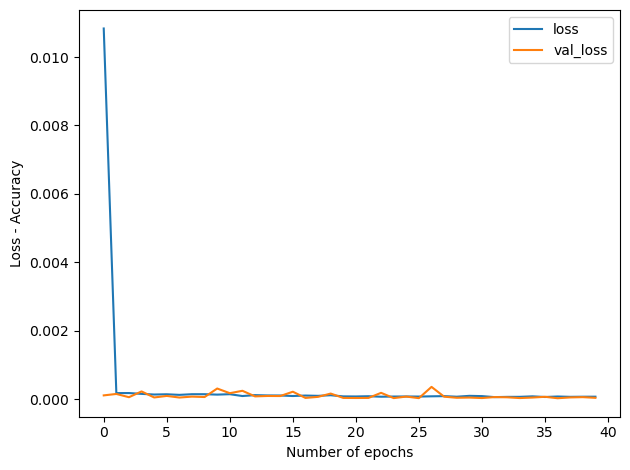

In [63]:
plot_training_history(fitted_rnn_1)

  4/235 [..............................] - ETA: 4s 

2022-11-19 19:19:39.628868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 21ms/step


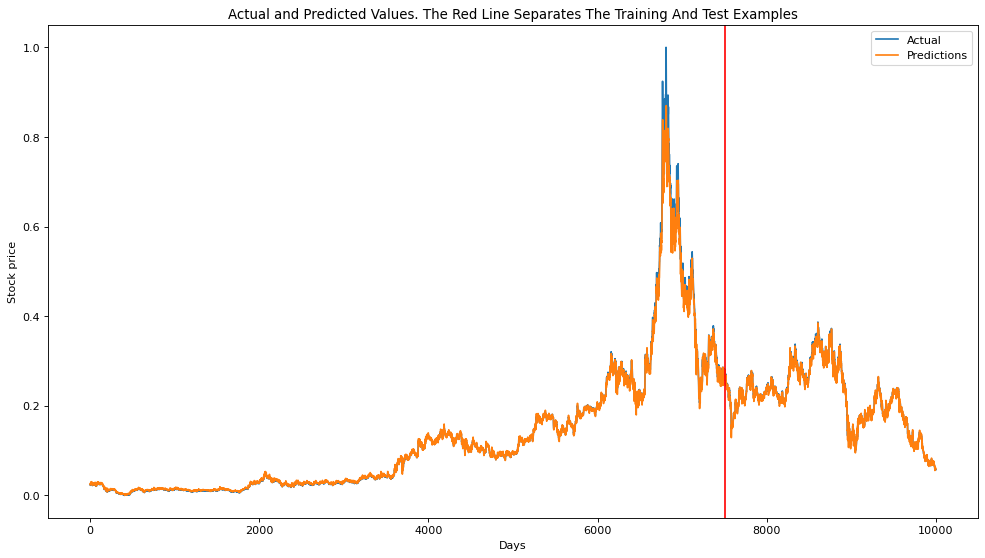

In [64]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_rnn_1 = fitted_rnn_1.model.predict(X_train)
    val_predict_rnn_1 = fitted_rnn_1.model.predict(X_val)
plot_result(y_train, y_val, train_predict_rnn_1, val_predict_rnn_1)

##### Experimenting with the activation function and learning rate scheduling techniques.

In [44]:
import math

# Function to experiment with optimizer and learning rate.
def create_RNN_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = 0
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    else:
        optimizing_function = keras.optimizers.RMSprop()

    model.compile(loss='mean_squared_error',
                  optimizer=optimizing_function)
    return model


initial_learning_rate = 0.01
time_decay = initial_learning_rate / EPOCH_COUNT

# Step decay for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Exponential decay for learning rate
def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)


callbacks_decay = [keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [67]:
'''
Running the vanilla RNN model with RMSProp and Adam with 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_vanilla = []
optimizers = ["Adam", "RMSProp"]
for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        model = create_RNN_2(n_hidden_units, n_dense_units,
                            input_shape, activation='tanh', optimizer=optimizer)
        # Training the RNN with multiple SimpleRNN layers
        fitted_model = 0
        with tf.device('/cpu:0'):
            if i == 0:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)
            else:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, callbacks=[callbacks_decay[i - 1]])

        predictions = fitted_model.model.predict(X_val)
        val_mse = mean_squared_error(
            y_val.reshape(y_val.shape[0], 1), predictions)
        results_vanilla.append((optimizer, callback_decay_keys[i], val_mse))


Epoch 1/40
  5/235 [..............................] - ETA: 3s - loss: 0.0502  

2022-11-19 19:27:01.477663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


231/235 [============================>.] - ETA: 0s - loss: 0.0019

2022-11-19 19:27:04.442947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 15ms/step - loss: 0.0018 - val_loss: 1.2409e-04
Epoch 2/40
235/235 [==============================] - 4s 16ms/step - loss: 1.6030e-04 - val_loss: 1.4495e-04
Epoch 3/40
235/235 [==============================] - 3s 14ms/step - loss: 1.4812e-04 - val_loss: 9.5939e-05
Epoch 4/40
235/235 [==============================] - 4s 15ms/step - loss: 1.5208e-04 - val_loss: 9.3593e-05
Epoch 5/40
235/235 [==============================] - 4s 15ms/step - loss: 1.2675e-04 - val_loss: 1.7638e-04
Epoch 6/40
235/235 [==============================] - 4s 16ms/step - loss: 1.2167e-04 - val_loss: 7.3123e-05
Epoch 7/40
235/235 [==============================] - 4s 16ms/step - loss: 1.1378e-04 - val_loss: 7.8355e-05
Epoch 8/40
235/235 [==============================] - 3s 14ms/step - loss: 1.1132e-04 - val_loss: 7.3280e-05
Epoch 9/40
235/235 [==============================] - 3s 15ms/step - loss: 1.0335e-04 - val_loss: 8.9470e-05
Epoch 10/40
235/235 [=============

2022-11-19 19:29:25.169904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 26ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40
  6/235 [..............................] - ETA: 2s - loss: 0.1453      

2022-11-19 19:29:27.571711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/235 [============================>.] - ETA: 0s - loss: 0.0040

2022-11-19 19:29:30.632583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 16ms/step - loss: 0.0040 - val_loss: 2.0890e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
235/235 [==============================] - 3s 15ms/step - loss: 1.2980e-04 - val_loss: 1.0294e-04 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
235/235 [==============================] - 3s 14ms/step - loss: 1.1764e-04 - val_loss: 1.1944e-04 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
235/235 [==============================] - 3s 14ms/step - loss: 1.2446e-04 - val_loss: 4.5900e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
235/235 [==============================] - 4s 15ms/step - loss: 1.0138e-04 - val_loss: 3.9551e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/40
235/235 [==============================] - 4s 16ms/step - loss: 9.4280e-05 - va

2022-11-19 19:31:47.355427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 26ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40
  5/235 [..............................] - ETA: 2s - loss: 0.0940  

2022-11-19 19:31:49.718471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/235 [============================>.] - ETA: 0s - loss: 0.0033

2022-11-19 19:31:52.619214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 15ms/step - loss: 0.0033 - val_loss: 7.6003e-05 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 3s 14ms/step - loss: 1.3919e-04 - val_loss: 6.1425e-05 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 3s 14ms/step - loss: 1.2443e-04 - val_loss: 6.9748e-05 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 3s 14ms/step - loss: 1.0595e-04 - val_loss: 5.4698e-05 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 3s 15ms/step - loss: 1.0020e-04 - val_loss: 4.9935e-05 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40

2022-11-19 19:34:04.204912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 25ms/step
Epoch 1/40
  1/235 [..............................] - ETA: 1:27 - loss: 0.0027

2022-11-19 19:34:06.509622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


232/235 [============================>.] - ETA: 0s - loss: 0.0020

2022-11-19 19:34:09.771106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 4s 17ms/step - loss: 0.0020 - val_loss: 1.0520e-04
Epoch 2/40
235/235 [==============================] - 4s 16ms/step - loss: 2.6653e-04 - val_loss: 2.2080e-04
Epoch 3/40
235/235 [==============================] - 4s 16ms/step - loss: 1.9788e-04 - val_loss: 0.0014
Epoch 4/40
235/235 [==============================] - 4s 17ms/step - loss: 1.6924e-04 - val_loss: 8.7873e-04
Epoch 5/40
235/235 [==============================] - 4s 16ms/step - loss: 1.4813e-04 - val_loss: 9.5856e-05
Epoch 6/40
235/235 [==============================] - 4s 17ms/step - loss: 1.3454e-04 - val_loss: 1.6654e-04
Epoch 7/40
235/235 [==============================] - 4s 18ms/step - loss: 1.2922e-04 - val_loss: 1.1912e-04
Epoch 8/40
235/235 [==============================] - 4s 17ms/step - loss: 1.1420e-04 - val_loss: 1.9447e-04
Epoch 9/40
235/235 [==============================] - 4s 18ms/step - loss: 1.1634e-04 - val_loss: 3.5859e-04
Epoch 10/40
235/235 [=================

2022-11-19 19:37:03.688573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 3s 31ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40
  1/235 [..............................] - ETA: 1:31 - loss: 0.0228

2022-11-19 19:37:06.474347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/235 [============================>.] - ETA: 0s - loss: 0.1392

2022-11-19 19:37:10.280910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 5s 19ms/step - loss: 0.1393 - val_loss: 0.1520 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
235/235 [==============================] - 4s 19ms/step - loss: 0.1125 - val_loss: 0.0384 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
235/235 [==============================] - 4s 19ms/step - loss: 0.1108 - val_loss: 0.1242 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
235/235 [==============================] - 4s 19ms/step - loss: 0.1087 - val_loss: 0.1184 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
235/235 [==============================] - 5s 19ms/step - loss: 0.1033 - val_loss: 0.0101 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/40
235/235 [==============================] - 5s 19ms/step - loss: 0.0979 - val_loss: 0.1451 - lr: 0.0100

Epoch 7: Le

2022-11-19 19:40:06.942199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 3s 32ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40
  1/235 [..............................] - ETA: 1:31 - loss: 0.0087

2022-11-19 19:40:09.768449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/235 [============================>.] - ETA: 0s - loss: 0.1548

2022-11-19 19:40:13.544086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 5s 19ms/step - loss: 0.1542 - val_loss: 0.1374 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 5s 19ms/step - loss: 0.0682 - val_loss: 0.0696 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 5s 22ms/step - loss: 0.0943 - val_loss: 0.0615 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 5s 20ms/step - loss: 0.0433 - val_loss: 0.0248 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 5s 19ms/step - loss: 0.0356 - val_loss: 0.0023 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40
235/235 [==========================

2022-11-19 19:43:06.231105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 3s 32ms/step


In [68]:
df = pd.DataFrame(results_vanilla, columns=[
                  "Optimizer", "Decay type", "Val MSE"])
df

,Optimizer,Decay type,Val MSE
0,Adam,constant,0.000035
1,Adam,step_decay,0.000140
2,Adam,exp_decay,0.000062
3,RMSProp,constant,0.000040
4,RMSProp,step_decay,0.001851
5,RMSProp,exp_decay,0.000046


In [74]:
# Based on the above results, Adam with constant lr was the best
optimized_rnn_2 = create_RNN_2(n_hidden_units, n_dense_units,
                               input_shape, activation='tanh', optimizer=keras.optimizers.Adam())

with tf.device('/cpu:0'):
    fitted_optimized_rnn_2 = optimized_rnn_2.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)


Epoch 1/40
  1/235 [..............................] - ETA: 1:42 - loss: 0.0056

2022-11-19 20:28:58.823537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0010

2022-11-19 20:29:02.395099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 5s 18ms/step - loss: 0.0010 - val_loss: 1.5129e-04
Epoch 2/40
235/235 [==============================] - 4s 16ms/step - loss: 2.5690e-04 - val_loss: 7.7659e-05
Epoch 3/40
235/235 [==============================] - 4s 16ms/step - loss: 1.9014e-04 - val_loss: 2.5197e-04
Epoch 4/40
235/235 [==============================] - 4s 16ms/step - loss: 1.7137e-04 - val_loss: 7.6033e-04
Epoch 5/40
235/235 [==============================] - 4s 18ms/step - loss: 1.5311e-04 - val_loss: 8.0157e-05
Epoch 6/40
235/235 [==============================] - 4s 18ms/step - loss: 1.2670e-04 - val_loss: 7.6379e-05
Epoch 7/40
235/235 [==============================] - 4s 16ms/step - loss: 1.1958e-04 - val_loss: 1.4244e-04
Epoch 8/40
235/235 [==============================] - 4s 17ms/step - loss: 1.0972e-04 - val_loss: 6.5678e-05
Epoch 9/40
235/235 [==============================] - 4s 18ms/step - loss: 1.0802e-04 - val_loss: 6.7632e-05
Epoch 10/40
235/235 [=============

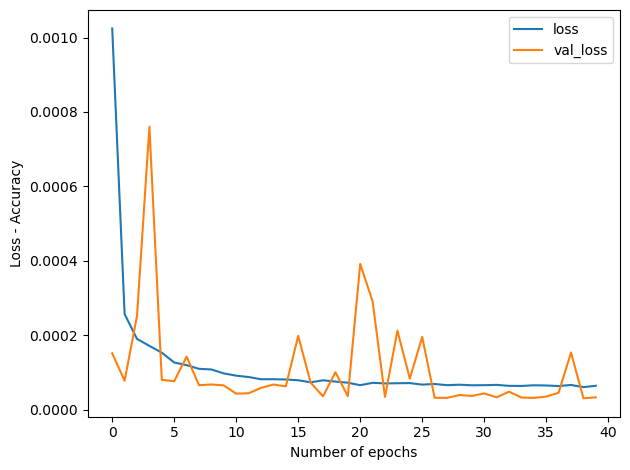

In [75]:
plot_training_history(fitted_optimized_rnn_2)

78/78 [==============================] - 1s 9ms/step


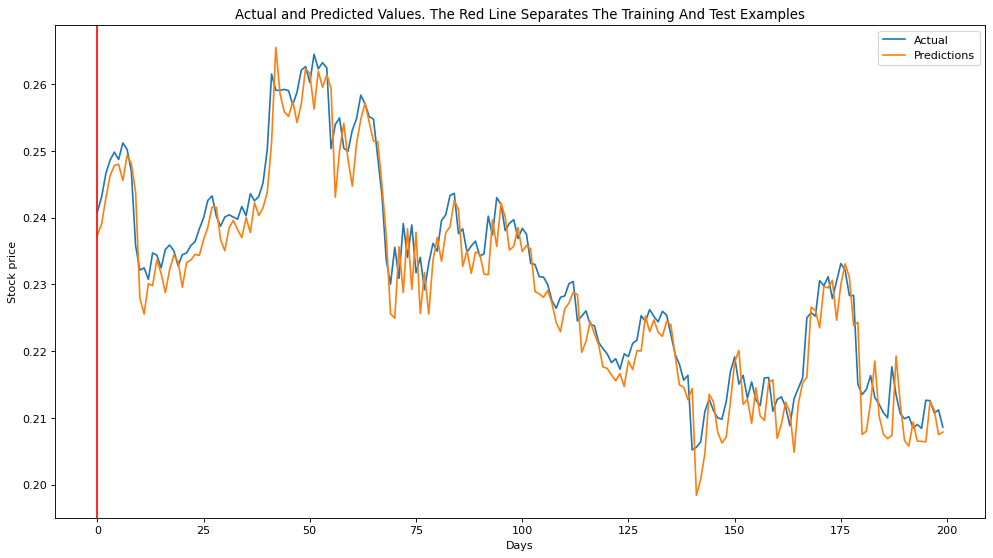

In [93]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_optimized_rnn_2 = fitted_optimized_rnn_2.model.predict(X_train)
    val_predict_optimized_rnn_2 = fitted_optimized_rnn_2.model.predict(X_val)
# plot_result(y_train, y_val, train_predict_optimized_rnn_2,
#             val_predict_optimized_rnn_2)
plot_result(np.array([]), y_val[500:700], np.array([]),
            val_predict_optimized_rnn_2[500:700])


### Performance metrics

In [77]:
# Get training and validation MSEs for all variations of the RNN
train_mse_vanilla, val_mse_vanilla = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_vanilla), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_vanilla)

train_mse_rnn_1, val_mse_rnn_1 = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_rnn_1), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_rnn_1)

train_mse_optimized_rnn_2, val_mse_optimized_rnn_2 = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_optimized_rnn_2), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_optimized_rnn_2)


In [78]:
rnn_summary = [("Vanilla RNN", train_mse_vanilla, val_mse_vanilla),
               ("Stacked RNN", train_mse_rnn_1, val_mse_rnn_1), 
               ("Optimized Vanilla RNN", train_mse_optimized_rnn_2, val_mse_optimized_rnn_2)]

rnn_summary_df = pd.DataFrame(rnn_summary, columns=["Model", "Train MSE", "Val MSE"])
rnn_summary_df


,Model,Train MSE,Val MSE
0,Vanilla RNN,0.000045,0.000035
1,Stacked RNN,0.000097,0.000041
2,Optimized Vanilla RNN,0.000051,0.000033


### Experimentation with window size

(7479, 50, 1) (7479, 1, 1)
(2460, 50, 1) (2460, 1, 1)
Epoch 1/10


2022-11-20 19:26:54.382989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - ETA: 0s - loss: 0.0034

2022-11-20 19:27:13.956093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 25s 106ms/step - loss: 0.0034 - val_loss: 3.0765e-04
Epoch 2/10
234/234 [==============================] - 26s 112ms/step - loss: 2.4339e-04 - val_loss: 1.6991e-04
Epoch 3/10
234/234 [==============================] - 26s 113ms/step - loss: 1.9375e-04 - val_loss: 7.9250e-05
Epoch 4/10
234/234 [==============================] - 26s 113ms/step - loss: 2.6328e-04 - val_loss: 6.4456e-05
Epoch 5/10
234/234 [==============================] - 28s 119ms/step - loss: 1.3942e-04 - val_loss: 2.3179e-04
Epoch 6/10
234/234 [==============================] - 26s 112ms/step - loss: 2.1040e-04 - val_loss: 5.7403e-05
Epoch 7/10
234/234 [==============================] - 25s 108ms/step - loss: 1.6740e-04 - val_loss: 0.0012
Epoch 8/10
234/234 [==============================] - 25s 107ms/step - loss: 1.4883e-04 - val_loss: 1.0312e-04
Epoch 9/10
234/234 [==============================] - 25s 106ms/step - loss: 1.2757e-04 - val_loss: 3.7373e-05
Epoch 10/10
  1/234 

2022-11-20 19:31:12.438521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 5s 69ms/step


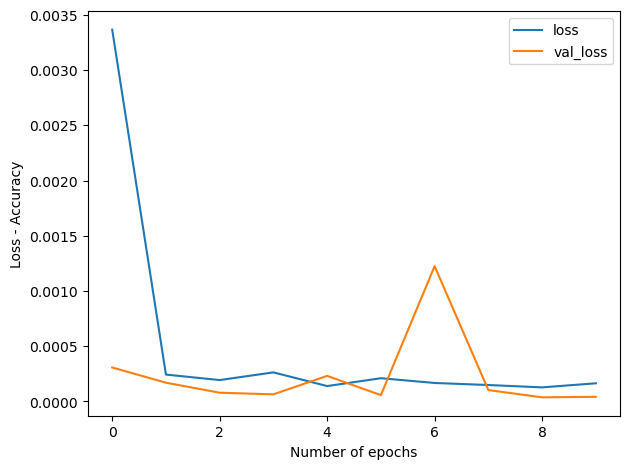

Val MSE = 4.2136889331606734e-05
(7429, 100, 1) (7429, 1, 1)
(2410, 100, 1) (2410, 1, 1)
Epoch 1/10


2022-11-20 19:31:37.489493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - ETA: 0s - loss: 0.0032

2022-11-20 19:32:16.354116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 50s 212ms/step - loss: 0.0032 - val_loss: 2.9480e-04
Epoch 2/10
233/233 [==============================] - 42s 182ms/step - loss: 2.1532e-04 - val_loss: 2.2262e-04
Epoch 3/10
233/233 [==============================] - 41s 178ms/step - loss: 2.2169e-04 - val_loss: 7.1634e-04
Epoch 4/10
233/233 [==============================] - 41s 178ms/step - loss: 2.2874e-04 - val_loss: 2.4520e-04
Epoch 5/10
233/233 [==============================] - 41s 178ms/step - loss: 2.3861e-04 - val_loss: 6.4048e-05
Epoch 6/10
233/233 [==============================] - 41s 178ms/step - loss: 1.8534e-04 - val_loss: 7.6985e-05
Epoch 7/10
233/233 [==============================] - 42s 180ms/step - loss: 1.3754e-04 - val_loss: 9.3513e-05
Epoch 8/10
233/233 [==============================] - 41s 178ms/step - loss: 1.7504e-04 - val_loss: 6.0765e-05
Epoch 9/10
233/233 [==============================] - 42s 181ms/step - loss: 1.3967e-04 - val_loss: 1.1436e-04
Epoch 10/10
  1/

2022-11-20 19:38:43.867953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 9s 115ms/step


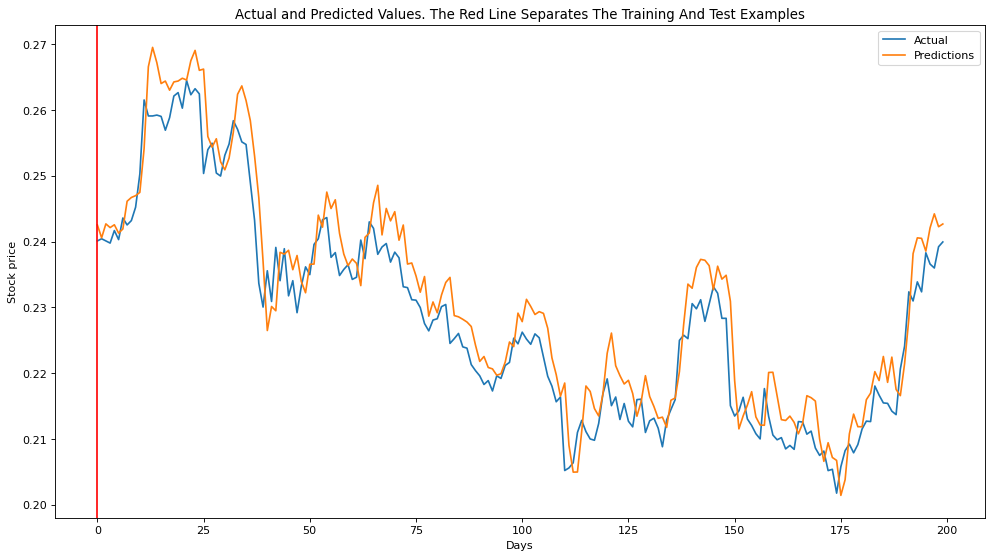

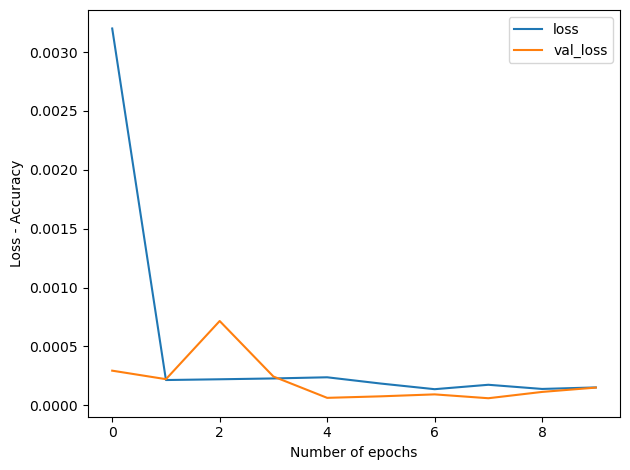

Val MSE = 0.00015108486244200524


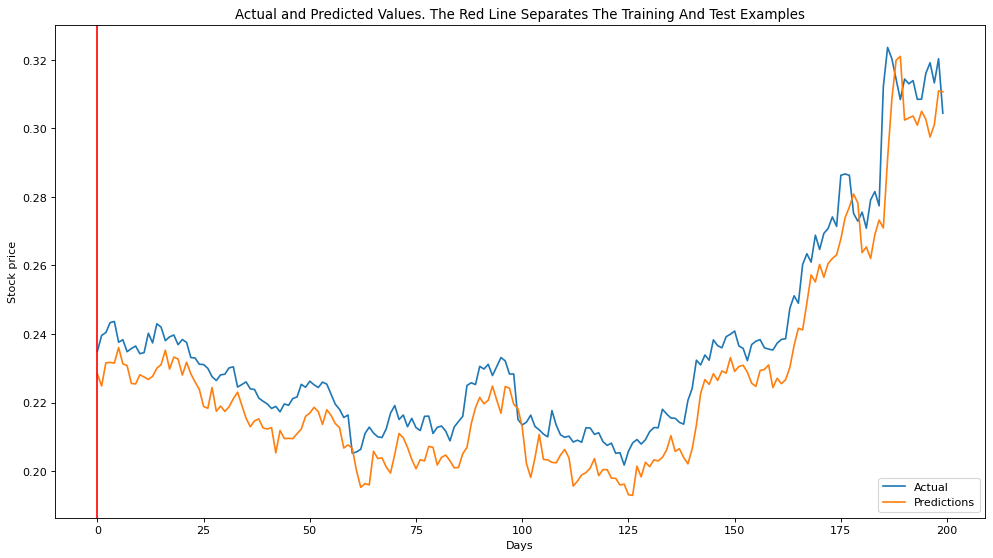

In [90]:
# Get the train features, train labels, test features, test labels
train_sizes = [50, 100]
label_count = 1

for train_size in train_sizes:
    X_train_e, y_train_e = get_data_splits(
        training_set, train_size, label_count)
    X_val_e, y_val_e = get_data_splits(
        validation_set, train_size, label_count)

    print(X_train_e.shape, y_train_e.shape)
    print(X_val_e.shape, y_val_e.shape)

    model = create_RNN_1([n_hidden_units, n_hidden_units, n_hidden_units], n_dense_units,
                               (train_size, 1), activation='tanh')
    with tf.device('/cpu:0'):
        fitted_model = model.fit(X_train_e, y_train_e, validation_data=(
            X_val_e, y_val_e), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT - 30)
        train_predict = fitted_model.model.predict(X_train_e)
        val_predict = fitted_model.model.predict(X_val_e)
    # Plotting actual stock prices and predictions
    plot_training_history(fitted_model)
    plot_result(np.array([]), y_val_e[500:700], np.array([]), val_predict[500:700])
    print("Val MSE =", mean_squared_error(
        y_val_e.reshape(y_val_e.shape[0], 1), val_predict))
    